In [1]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("HF_Token")

In [2]:
import json
import torch
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
import torch.nn.functional as F
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import random

# Load JSON data
with open("/kaggle/input/intents/intents.json", "r") as file:
    intents = json.load(file)

# Remove duplicate intent tags
unique_intents = []
seen_tags = set()
for intent in intents:
    if intent["tag"] not in seen_tags:
        unique_intents.append(intent)
        seen_tags.add(intent["tag"])

# Ensure unique intent tags
intent_tags = [intent["tag"] for intent in unique_intents]
num_labels = len(intent_tags)

# Create label mapping
label_map = {tag: i for i, tag in enumerate(intent_tags)}

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load BERT tokenizer & model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', token=secret_value_0)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels, token=secret_value_0)
model.to(device)

# Define Dataset
class IntentDataset(Dataset):
    def __init__(self, intents, tokenizer):
        self.texts = []
        self.labels = []
        self.label_map = label_map

        for intent in intents:
            for pattern in intent["patterns"]:
                self.texts.append(pattern)
                self.labels.append(self.label_map[intent["tag"]])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.long).to(device)

        encoding = tokenizer(text, truncation=True, padding="max_length", max_length=32, return_tensors="pt")
        item = {key: val.squeeze(0).to(device) for key, val in encoding.items()}  # Remove batch dim

        return item, label

# Load dataset & dataloader
dataset = IntentDataset(unique_intents, tokenizer)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)  # Increased batch size

# Compute class weights
labels = [dataset.label_map[intent["tag"]] for intent in unique_intents for _ in intent["patterns"]]
class_weights = compute_class_weight("balanced", classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define optimizer & loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)  # Lower learning rate
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)  # Use class-weighted loss

# Training loop
epochs = 90  # Increased from 20 to 50 for better training
model.train()

for epoch in range(epochs):
    total_loss = 0
    for batch in dataloader:
        inputs, labels = batch
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{epochs} - Average Loss: {avg_loss:.4f}")

# Function to predict intent
def predict_intent(user_input):
    model.eval()
    inputs = tokenizer(user_input, return_tensors="pt", truncation=True, padding=True, max_length=32)
    inputs = {key: val.to(device) for key, val in inputs.items()}  # Move input to GPU

    with torch.no_grad():
        outputs = model(**inputs)

    predicted_label = torch.argmax(outputs.logits).item()
    
    # Map predicted label to intent
    intent_tag = list(dataset.label_map.keys())[predicted_label]

    # Fetch a random response for the predicted intent
    for intent in unique_intents:
        if intent["tag"] == intent_tag:
            return random.choice(intent["responses"])

# Run chatbot interaction
print("🤖 Chatbot is ready! Type 'exit' to stop.")
while True:
    user_input = input("You: ")
    if user_input.lower() in ["exit", "quit"]:
        print("Bot: Goodbye! 👋")
        break
    response = predict_intent(user_input)
    print("Bot:", response)


Using device: cuda


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/90 - Average Loss: 5.6619
Epoch 2/90 - Average Loss: 5.5883
Epoch 3/90 - Average Loss: 5.5470
Epoch 4/90 - Average Loss: 5.4290
Epoch 5/90 - Average Loss: 5.2496
Epoch 6/90 - Average Loss: 5.0645
Epoch 7/90 - Average Loss: 4.8741
Epoch 8/90 - Average Loss: 4.7122
Epoch 9/90 - Average Loss: 4.5314
Epoch 10/90 - Average Loss: 4.3852
Epoch 11/90 - Average Loss: 4.2249
Epoch 12/90 - Average Loss: 4.0838
Epoch 13/90 - Average Loss: 3.9303
Epoch 14/90 - Average Loss: 3.7829
Epoch 15/90 - Average Loss: 3.6581
Epoch 16/90 - Average Loss: 3.5259
Epoch 17/90 - Average Loss: 3.3789
Epoch 18/90 - Average Loss: 3.2480
Epoch 19/90 - Average Loss: 3.1250
Epoch 20/90 - Average Loss: 2.9910
Epoch 21/90 - Average Loss: 2.8648
Epoch 22/90 - Average Loss: 2.7338
Epoch 23/90 - Average Loss: 2.6204
Epoch 24/90 - Average Loss: 2.5009
Epoch 25/90 - Average Loss: 2.3891
Epoch 26/90 - Average Loss: 2.2775
Epoch 27/90 - Average Loss: 2.1512
Epoch 28/90 - Average Loss: 2.0413
Epoch 29/90 - Average Loss: 1

You:  exit


Bot: Goodbye! 👋


In [3]:
import torch
from torch.utils.data import random_split
from sklearn.metrics import accuracy_score

# Split dataset into training (80%) and test (20%) sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Function to evaluate model accuracy
def evaluate_model(model, test_dataloader):
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for batch in test_dataloader:
            inputs, labels = batch
            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

# Compute accuracy
test_accuracy = evaluate_model(model, test_dataloader)
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 1.0000


In [4]:
def evaluate_train_accuracy(model, train_dataloader):
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for batch in train_dataloader:
            inputs, labels = batch
            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

# Compute Training Accuracy
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False)
train_accuracy = evaluate_train_accuracy(model, train_dataloader)
print(f"Training Accuracy: {train_accuracy:.4f}")


Training Accuracy: 0.9939


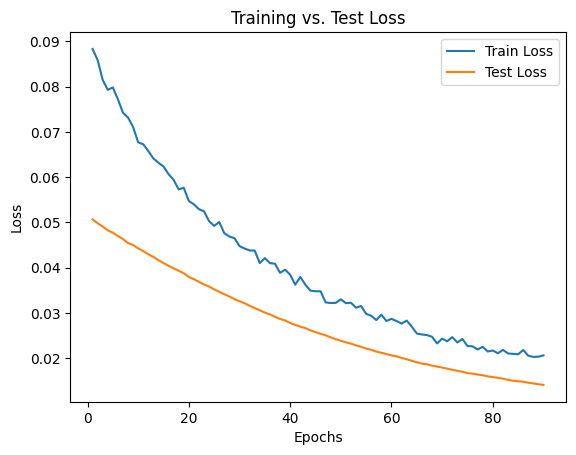

In [5]:
import matplotlib.pyplot as plt

# Assuming you store losses during training like this:
train_losses = []
test_losses = []

for epoch in range(epochs):
    total_train_loss = 0
    total_test_loss = 0

    model.train()
    for batch in train_dataloader:
        inputs, labels = batch
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    model.eval()
    with torch.no_grad():
        for batch in test_dataloader:
            inputs, labels = batch
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            total_test_loss += loss.item()

    train_losses.append(total_train_loss / len(train_dataloader))
    test_losses.append(total_test_loss / len(test_dataloader))

# Plot the loss curves
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs+1), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs. Test Loss")
plt.show()


In [6]:
test_inputs = [
    "Tell me a joke", 
    "Recommend a good book", 
    "What's the weather like today?", 
    "How can I save money?", 
    "How do I meditate?"
]

for input_text in test_inputs:
    response = predict_intent(input_text)
    print(f"User: {input_text}\nBot: {response}\n")


User: Tell me a joke
Bot: Why don't skeletons fight each other? They don't have the guts!

User: Recommend a good book
Bot: Reading books can broaden your knowledge, enhance creativity, and provide a great way to relax.

User: What's the weather like today?
Bot: You can check the weather on a weather app or website.

User: How can I save money?
Bot: Investing in stocks, mutual funds, or real estate can help grow your wealth over time.

User: How do I meditate?
Bot: Meditation can reduce stress, improve focus, and promote emotional well-being.



In [7]:
# Define save paths
model_path = "bert_chatbot_model.pth"
tokenizer_path = "bert_chatbot_tokenizer"

# Save model state dictionary
torch.save(model.state_dict(), model_path)

# Save tokenizer
tokenizer.save_pretrained(tokenizer_path)

print(f"Model saved to {model_path}")
print(f"Tokenizer saved to {tokenizer_path}")

Model saved to bert_chatbot_model.pth
Tokenizer saved to bert_chatbot_tokenizer


In [8]:
model.save_pretrained("chatbot_model")
tokenizer.save_pretrained("chatbot_model")

('chatbot_model/tokenizer_config.json',
 'chatbot_model/special_tokens_map.json',
 'chatbot_model/vocab.txt',
 'chatbot_model/added_tokens.json')